# Final Project - DA 353

## Dr. Bonifonte
## Minh Le & Yen Nguyen


### I. Background and Introduction

The adoption of electric vehicles (EVs) is increasing worldwide, mainly driven by growing awareness of environmental issues and technological advancements. These types of vehicles are now favored and recognized by the majority of consumers. With the increasing number of new energy electric vehicles, the demand for charging stations for these vehicles is also increasing. This makes the strategic placement of charging stations crucial, helping the government optimize infrastructure efficiency by minimizing the need for excessive stations. Finding the right locations for these stations is therefore important, ensuring they can provide convenient access for all EV users, while contributing to a more sustainable future of transportation.

For this project, we aim to optimize the allocation of electric vehicles charging stations locations that effectively minimize the number of stations. We chose Washington state for our optimization model. Since the current data is too large, we plan to focus on the metropolitan area in Washington state, such as Seattle, to reduce the complexity of the problem. Based on the given dataset provided by data.gov about the registered electric vehicles, we are hoping to effectively design and build strategic placements of stations that can cover all the locations and meet the demand of those registered cars.


### II. Data Preprocessing & Exploration
Now, we will select all the data we need for our optimization problem. We will only focus on the biggest city in Washington State, which is Seattle. 

In [1]:
# import packages
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import geopy.distance
import folium
from itertools import combinations, permutations, product
from math import sqrt

In [2]:
# load datset and select needed columns
df = pd.read_csv("./Electric_Vehicle_Population_Data.csv")
df = df[["VIN (1-10)", "County", "City", "Postal Code", "Electric Range", "Vehicle Location"]]
df.set_index("VIN (1-10)", inplace=True)

In [3]:
# select data that are from Seattle
df_seattle = df.loc[df["City"] == "Seattle"]
df_seattle.head()

,County,City,Postal Code,Electric Range,Vehicle Location
VIN (1-10),,,,,
5YJYGDEE1L,King,Seattle,98122.0,291,POINT (-122.30839 47.610365)
5YJSA1E4XK,King,Seattle,98109.0,270,POINT (-122.34848 47.632405)
5YJYGDEEXL,King,Seattle,98144.0,291,POINT (-122.30823 47.581975)
1N4AZ0CP0F,King,Seattle,98119.0,84,POINT (-122.363815 47.63046)
1N4AZ0CP6D,King,Seattle,98107.0,75,POINT (-122.37815 47.66866)


First, we want to explore the locations of all the registered vehicles. We will use `Postal Code` to identify where the EVs are registered in Seattle.

In [4]:
# select unique postal code in the dataset
unique_postal_codes = df_seattle['Postal Code'].unique()

# how many vehicles are there for each postal code?
postal_code_counts = df_seattle.groupby('Postal Code').size().reset_index(name='Count')

# Create a grid representation using postal codes
grid = {}

# Populate grid with coordinates
for index, row in df_seattle.iterrows():
    code = row['Postal Code']
    log = row["Vehicle Location"].split(" ")[1][1:]
    lat = row["Vehicle Location"].split(" ")[2][:-1]
    grid[code] = (float(lat), float(log))

We will now create a map to see the location of each `Postal Code`:

In [5]:
#Plot the map for model 1
map_mod_1 = folium.Map(location=[47.6062, -122.3321], zoom_start=10.45)
for key, value in grid.items():
    folium.Marker(location=value,
                    popup=key,
                    icon=folium.Icon(color='blue')).add_to(map_mod_1)
        
map_mod_1

For further development and analysis, we will convert the location of our `Postal Code` to a grid location.

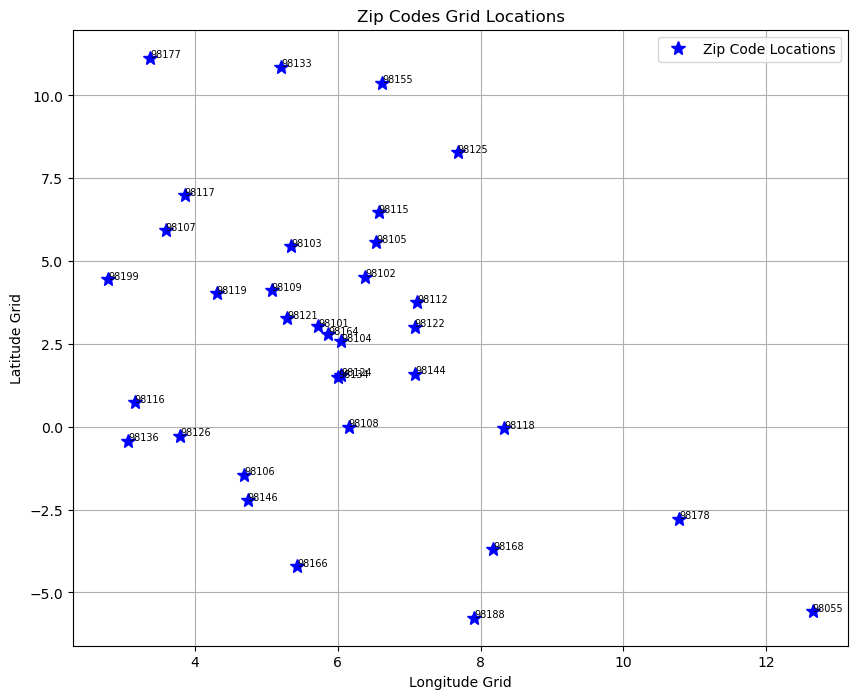

In [6]:
# Define maximum and minimum longitude and latitude ranges
min_lon, max_lon = -122.45, -122.25  
min_lat, max_lat = 47.55, 47.75  

# Define grid size
grid_size = 10

# Function to map longitude and latitude to grid location
def map_to_grid(lon, lat):
    lon_idx = (lon - min_lon) / (max_lon - min_lon) * grid_size
    lat_idx = (lat - min_lat) / (max_lat - min_lat) * grid_size
    return lon_idx, lat_idx

# Convert coordinates to grid locations
grid_locations = {zipcode: map_to_grid(lon, lat) for zipcode, (lat, lon) in grid.items()}

# Plot grid locations
plt.figure(figsize=(10, 8))
for zipcode, (lon_idx, lat_idx) in grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'b*', markersize = 10)
    plt.text(lon_idx, lat_idx, str(int(zipcode)), fontsize=7)

plt.title('Zip Codes Grid Locations')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.legend(['Zip Code Locations'])
plt.grid(True)
plt.show()

In [7]:
# Grid locations converted from the given longitudes and latitudes of postal codes
df = pd.DataFrame.from_dict(grid_locations, orient='index', columns=["Longitude", "Latitude"])

# Compute the maximum and minimum longitude and latitude converted grid locations
max_longitude = df["Longitude"].max()
min_longitude = df["Longitude"].min()
max_latitude = df["Latitude"].max()
min_latitude = df["Latitude"].min()

print("Maximum Longitude:", max_longitude)
print("Minimum Longitude:", min_longitude)
print("Maximum Latitude:", max_latitude)
print("Minimum Latitude:", min_latitude)

Maximum Longitude: 12.649999999999826
Minimum Longitude: 2.7907500000004464
Maximum Latitude: 11.13950000000001
Minimum Latitude: -5.763499999999684


Given the grid locations converted from zip code coordinates, we want to identify suitable candidate locations for charging stations. By determining the maximum and minimum coordinates of these converted grid locations, we establish the range within which candidate locations should be selected: longitude [3, 13] and latitude [-6, 12]. We prioritize **integer points** on the grid as potential candidate locations. This approach ensures that the selected locations align with the grid system's structure, facilitating the efficient placement of charging stations.

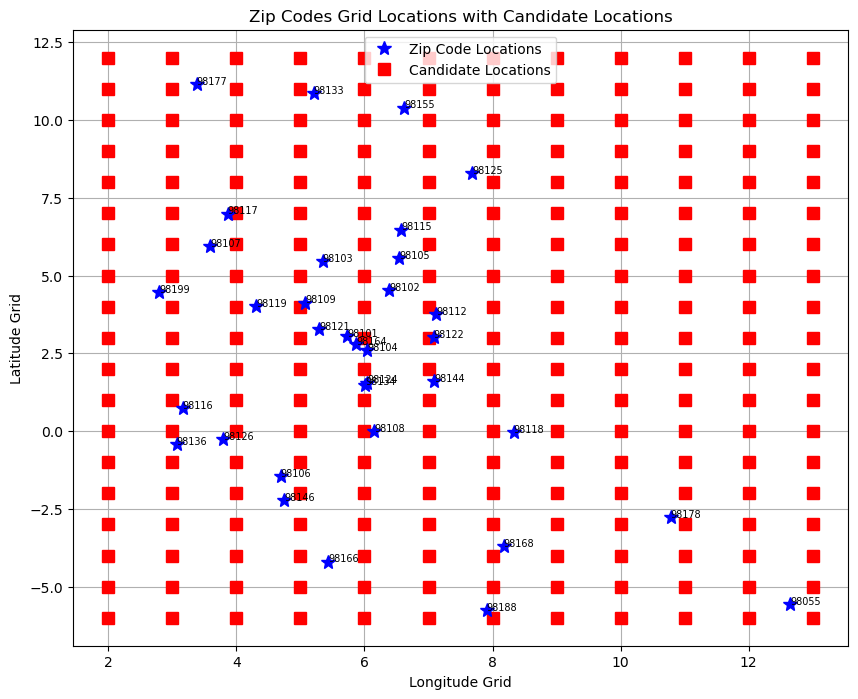

In [8]:
# Select candidate grid locations within the specified range
candidate_grid_locations = {idx: (i, j) for idx, (i, j) in enumerate([(i, j) for i in range(2, 14) for j in range(-6, 13)])}

# Plot grid locations
plt.figure(figsize=(10, 8))

# Plot candidate locations (red points)
for candidate, (lon_idx, lat_idx) in candidate_grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'rs', markersize = 8)

for zipcode, (lon_idx, lat_idx) in grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'b*', markersize = 10)
    plt.text(lon_idx, lat_idx, str(int(zipcode)), fontsize=7)

plt.title('Zip Codes Grid Locations with Candidate Locations')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
handles = [plt.Line2D([], [], marker='*', color='blue', linestyle='None', markersize=10),
           plt.Line2D([], [], marker='s', color='red', linestyle='None', markersize=8)]
labels = ['Zip Code Locations', 'Candidate Locations']
plt.legend(handles, labels)
plt.grid(True)
plt.show()

From the grid, it's clear that there's an empty space in the top-right corner, defined by longitude [10, 13] and latitude [-1, 12], where no blue points (representing postal codes) are present. Consequently, we can confidently exclude this area from our candidate location list for optimization purposes. By removing these points, we streamline our optimization model, focusing it on areas with existing postal codes and potentially enhancing its efficiency.

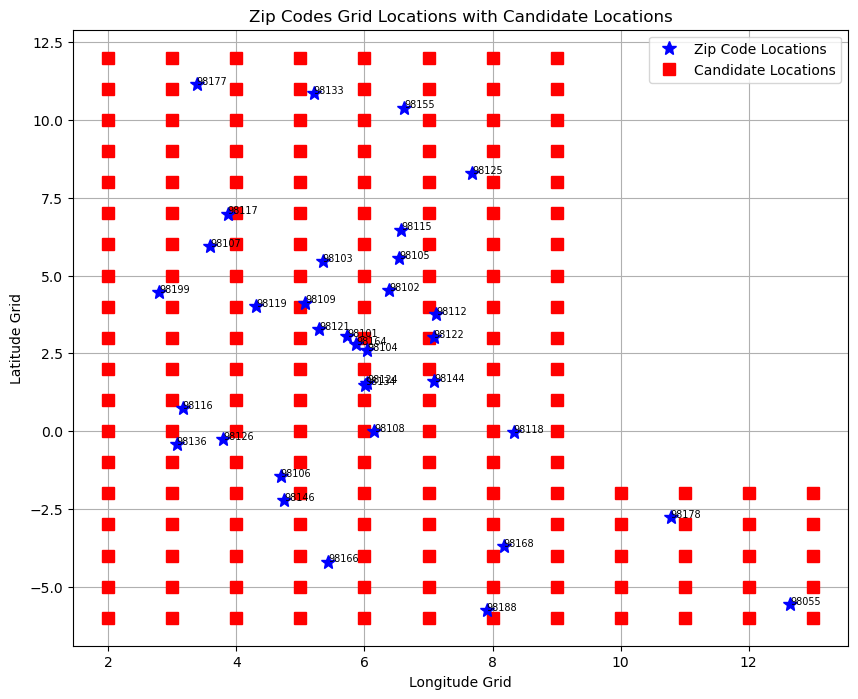

In [9]:
# Define the grid locations you want to remove
locations_to_remove = {(i, j) for i in range(10, 14) for j in range(-1, 13)}

# Remove the specified grid locations from candidate_grid_locations
candidate_grid_locations = {idx: (i, j) for idx, (i, j) in candidate_grid_locations.items() if (i, j) not in locations_to_remove}

# Plot grid locations
plt.figure(figsize=(10, 8))

# Plot candidate locations (red points)
for candidate, (lon_idx, lat_idx) in candidate_grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'rs', markersize = 8)

for zipcode, (lon_idx, lat_idx) in grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'b*', markersize = 10)
    plt.text(lon_idx, lat_idx, str(int(zipcode)), fontsize=7)

plt.title('Zip Codes Grid Locations with Candidate Locations')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
handles = [plt.Line2D([], [], marker='*', color='blue', linestyle='None', markersize=10),
           plt.Line2D([], [], marker='s', color='red', linestyle='None', markersize=8)]
labels = ['Zip Code Locations', 'Candidate Locations']
plt.legend(handles, labels)
plt.grid(True)
plt.show()


### III. Model Formulation

To streamline our project, we make the following assumptions:
- We assume uniform power consumption demand for each vehicle, approximating it based on the average power consumption of electric cars. 
- We consider the construction cost as well as the power capacity of a new station to be consistent across all locations and irrespective of demand variations.
- We assume the location of each vehicles is specified by `Postal Code`.

We want to develop a linear programming model to solve the problem. The structure of the model is:

1. <b> Set: </b>
    - Let $Z$ represent the set of postal codes obtained from the dataset.
    - Let $S$ denote the set of candidate charging locations.
2. <b> Data: </b>
    - $D$: the maximum certain distance threshold between the charging location and the vehicle.
    - $ST$: the maximum stations can be installed.
    - $S_j$: the maximum supply of the charging station $j$.
    - $d_{ij}$: the distance between vehicle in postal code $i$ ($i \in Z$) and station $j$ ($j \in S$).
    - $n_i$: the number of cars require charging in postal code $i$.

3. <b> Decision Variables: </b>
    - $C_{j}$: Binary variable indicating whether to open the charging station $j$, $j \in S$.
    - $X_{ij}$: Continuous variable representing the proportion of vehicles in postal code $i$ ($i \in Z$) chooses station $j$ ($j \in S$) for charging service.

4. <b> Objective Function: </b> Maximize the power coverage of the stations opened:
\begin{equation*} 
\max \displaystyle\sum_{i \in Z} n_i X_{ij}
\end{equation*}

5. <b> Constraints: </b>
    - Only charge at the stations that have been selected: $ X_{ij} <= C_{j} \quad \forall i\in Z, j\in S$.
    - Vehicle charging constraint: $\displaystyle \sum_{j\in S} X_{ij} \leq 1 \quad \forall i\in Z$.
    - Limit the distance between each postal code and its assigned charging station to a maximum threshold of D units: 
    $d_{ij} C_j \leq D \quad \forall i \in Z, j \in S$.
    - Ensure that the total demand (based on the number of cars requiring charging) supplied by each charging station does not exceed its maximum supply:
    $\displaystyle \sum_{i \in Z} n_i X_{ij} \leq S_j \quad \forall j\in S$.
    -  Ensure that only 100 stations are opened: $\displaystyle \sum_{j \in S} C_j <= ST$.

### IV. Model Implementation

In [10]:
# Function to create the Euclidean distances between the charging locations and the vehicles in zip code i
def distance(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return sqrt(dx*dx + dy*dy)

# List of postal codes and list of candidate indices
codes = grid_locations.keys()
candidate = candidate_grid_locations.keys()

# Generate a list of pairs of postal codes and the candidate indices
cartesian_prod = list(product(codes, candidate))

# Compute the distances between each pair of code and candidate stations
distances = {(c, f): distance(grid_locations[c], candidate_grid_locations[f]) for c, f in cartesian_prod}

We now set the maximum distance threshold between the charging location and the vehicle to be within 2.0 unit in grid locations. 

In [11]:
def maximum_dist_thres(threshold):
    dict = {}
    for c, f in cartesian_prod:
        if distances[(c, f)] <= threshold:
            dict[(c, f)] = distances[(c, f)]
    return dict

threshold = 2.0 # set the threshold to be 2.0
distances_filtered = maximum_dist_thres(threshold)

# restrict the distance to be within a certain threshold and store it into a new set
ck = []
cand = {}
for i, j in distances_filtered.keys():
    ck.append((i, j))
    cand[j] = candidate_grid_locations[j]

Then, we will solve the model using Gurobi using the set of candidate locations that driver will choose within the tolerable distance. In addition, here are the assumptions we made for model implementation:
- We have a fixed budget so we are only able to open 100 stations (`ST = 100`). 
- Maximum supply of each charging station: 500 cars (`S = 1000`)
- Maximum certain distance threshold between the charging location and the vehicle: 2.0 in grid distance(`D = 2.0`)

In [12]:
# Model 1
model1 = gp.Model("Station Cover")
model1.Params.LogToConsole = 0 # Suppress noisy output

## Data
### Number of cars requires charging at location i
n = postal_code_counts.set_index('Postal Code')['Count'].to_dict()

## Variables: 
### Whether to open charging station j?
C = model1.addVars(cand.keys(), vtype = GRB.BINARY, name = "c")

### The proportion of vehicles in postal code i choose station j for charging service
X_var = model1.addVars(ck, lb = 0.0, ub = 1.0, vtype = GRB.CONTINUOUS, name = "x")

## Objective
model1.setObjective(gp.quicksum(X_var[i, j] * n[i] for i, j in ck), GRB.MAXIMIZE)

## Constraints
### Vehicle charging constraint
model1.addConstrs(gp.quicksum(X_var[i, j] for j in cand.keys() if (i, j) in ck) <= 1 for i in grid_locations.keys())

### Supply-Demand balance constraint
model1.addConstrs(gp.quicksum(n[i] * X_var[i, j] for i in grid_locations.keys() if (i, j) in ck) <= 200 for j in cand.keys())

### Restrict the number of station to be constructed#
model1.addConstr(gp.quicksum(C[j] for j in cand.keys()) <= 100)

### Can be charge only when there is charging location
model1.addConstrs(X_var[i, j] <= C[j] for i, j in ck)

# optimize model
model1.optimize()

if model1.status == GRB.OPTIMAL:
    print("Optimal Solution:")
    print("Number of vehicles can be covered:", round(model1.ObjVal) , "vehicles")
    result = []
    for j in cand.keys():
        if C[j].x > 0.5:
            result.append(j)
else:
    print("No optimal solution found.")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-06
Optimal Solution:
Number of vehicles can be covered: 19810 vehicles


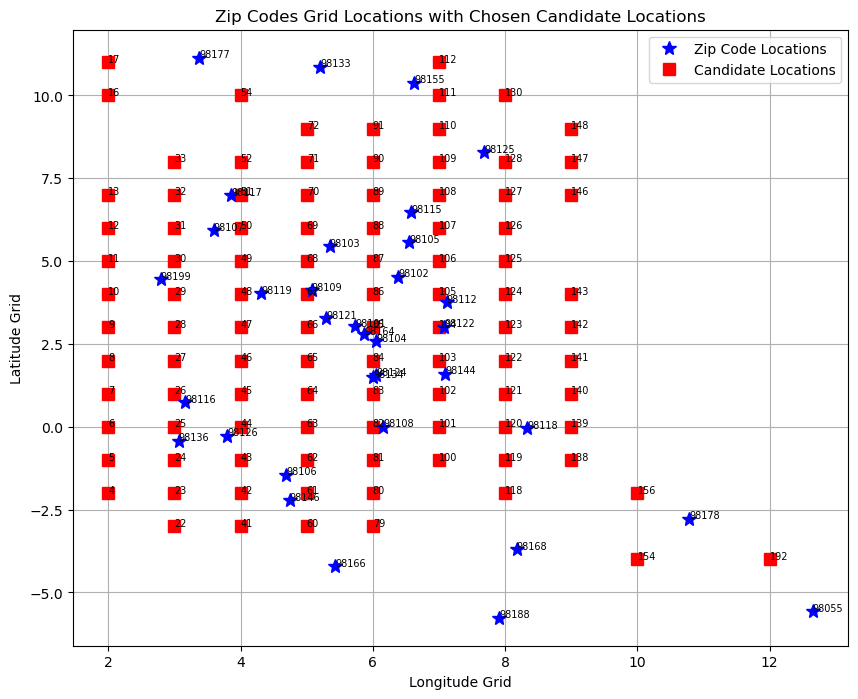

In [13]:
# Select the chosen candidate locations after optimizing using Gurobi
chosen_locations = {idx: (i, j) for idx, (i, j) in candidate_grid_locations.items() if idx in result}


# Plot grid locations
plt.figure(figsize=(10, 8))

# Plot candidate locations (red points)
for candidate, (lon_idx, lat_idx) in chosen_locations.items():
    plt.plot(lon_idx, lat_idx, 'rs', markersize = 8, label='Candidate Locations')
    plt.text(lon_idx, lat_idx, str(int(candidate)), fontsize=7)

for zipcode, (lon_idx, lat_idx) in grid_locations.items():
    plt.plot(lon_idx, lat_idx, 'b*', markersize = 10, label='Zip Code Locations')
    plt.text(lon_idx, lat_idx, str(int(zipcode)), fontsize=7)

plt.title('Zip Codes Grid Locations with Chosen Candidate Locations')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
handles = [plt.Line2D([], [], marker='*', color='blue', linestyle='None', markersize=10),
           plt.Line2D([], [], marker='s', color='red', linestyle='None', markersize=8)]
labels = ['Zip Code Locations', 'Candidate Locations']
plt.legend(handles, labels)
plt.grid(True)
plt.show()


In [14]:
result_table = []
for (i, j) in ck:
    if X_var[(i,j)].X > 0:
        result_table.append((i, j, round(X_var[(i,j)].X, 2), int(n[i] * X_var[(i,j)].X), distances[(i, j)]))

result_table = pd.DataFrame(result_table)
result_table.columns = ["Postal Codes", "Station", "Percentage coverage", "Number of cars", "Distances"]
result_table = result_table.sort_values(by="Postal Codes")
result_table

,Postal Codes,Station,Percentage coverage,Number of cars,Distances
130,98055.0,192,1.00,7,1.691846
52,98101.0,84,0.32,200,1.073305
51,98101.0,65,0.32,200,1.271803
79,98102.0,104,0.25,200,1.647304
78,98102.0,88,0.00,0,1.521056
...,...,...,...,...,...
53,98178.0,154,0.22,119,1.454549
54,98178.0,156,0.37,200,1.098505
55,98178.0,192,0.36,193,1.729946
103,98199.0,10,0.16,200,0.914689


### V. Sensitiviy Analysis

We will make a sensitivity test to figure out the key factor that shape our model. 

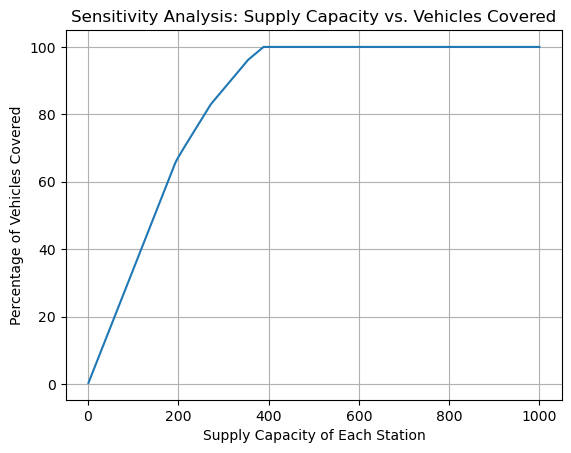

In [15]:
import matplotlib.pyplot as plt

# List to store the objective values for different supply capacities
coverage_values = []

# Define a range of supply capacities for each station
supply_capacity_range = range(1, 1001)  # Capacity power varies from 1 to 1000

for supply_capacity in supply_capacity_range:
    # Model creation
    model = gp.Model("Station Cover")
    model.Params.LogToConsole = 0  # Suppress noisy output

    # Data
    n = postal_code_counts.set_index('Postal Code')['Count'].to_dict()

    # Variables
    C = model.addVars(cand.keys(), vtype=GRB.BINARY, name="c")
    X_var = model.addVars(ck, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")

    # Objective
    model.setObjective(gp.quicksum(X_var[i, j] * n[i] for i, j in ck), GRB.MAXIMIZE)

    # Constraints
    model.addConstrs(gp.quicksum(X_var[i, j] for j in cand.keys() if (i, j) in ck) <= 1 for i in grid_locations.keys())
    model.addConstrs(gp.quicksum(n[i] * X_var[i, j] for i in grid_locations.keys() if (i, j) in ck) <= supply_capacity for j in cand.keys())
    model.addConstr(gp.quicksum(C[j] for j in cand.keys()) <= 100)
    model.addConstrs(X_var[i, j] <= C[j] for i, j in ck)

    # Optimize model
    model.optimize()

    # Store the objective value
    if model.status == GRB.OPTIMAL:
        # Compute the percentage of vehicles that the optimal solution can cover
        coverage_values.append(model.ObjVal/len(df_seattle)*100)
    else:
        coverage_values.append(0)  # If no optimal solution found, store 0

# Plot the sensitivity analysis results
plt.plot(supply_capacity_range, coverage_values)
plt.xlabel('Supply Capacity of Each Station')
plt.ylabel('Percentage of Vehicles Covered')
plt.title('Sensitivity Analysis: Supply Capacity vs. Vehicles Covered')
plt.grid(True)
plt.show()


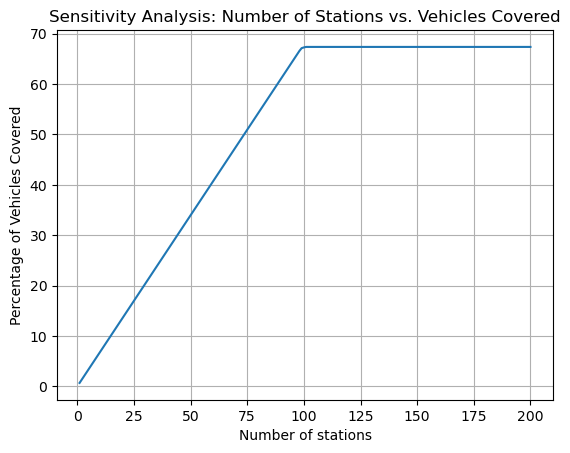

In [16]:
# List to store the objective values for different supply capacities
coverage_values = []

# Define a range of supply capacities for each station
num_locations_range = range(1, 201)  # Vary from 1 to 200 stations

for num_locations in num_locations_range:
    # Model creation
    model = gp.Model("Station Cover")
    model.Params.LogToConsole = 0  # Suppress noisy output

    # Data
    n = postal_code_counts.set_index('Postal Code')['Count'].to_dict()

    # Variables
    C = model.addVars(cand.keys(), vtype=GRB.BINARY, name="c")
    X_var = model.addVars(ck, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")

    # Objective
    model.setObjective(gp.quicksum(X_var[i, j] * n[i] for i, j in ck), GRB.MAXIMIZE)

    # Constraints
    model.addConstrs(gp.quicksum(X_var[i, j] for j in cand.keys() if (i, j) in ck) <= 1 for i in grid_locations.keys())
    model.addConstrs(gp.quicksum(n[i] * X_var[i, j] for i in grid_locations.keys() if (i, j) in ck) <= 200 for j in cand.keys())
    model.addConstr(gp.quicksum(C[j] for j in cand.keys()) <= num_locations)
    model.addConstrs(X_var[i, j] <= C[j] for i, j in ck)

    # Optimize model
    model.optimize()

    # Store the objective value
    if model.status == GRB.OPTIMAL:
        # Compute the percentage of vehicles that the optimal solution can cover
        coverage_values.append(model.ObjVal/len(df_seattle)*100)
    else:
        coverage_values.append(0)  # If no optimal solution found, store 0

# Plot the sensitivity analysis results
plt.plot(num_locations_range, coverage_values)
plt.xlabel('Number of stations')
plt.ylabel('Percentage of Vehicles Covered')
plt.title('Sensitivity Analysis: Number of Stations vs. Vehicles Covered')
plt.grid(True)
plt.show()


### VI. Model Validation & Evaluation

Compare with the allocation of EV charging stations in real life

In [17]:
# Define maximum and minimum longitude and latitude ranges
min_lon, max_lon = -122.45, -122.25  
min_lat, max_lat = 47.55, 47.75  

# Define grid size
grid_size = 10

# Define chosen grid locations (assuming 'result' contains grid indices)
chosen = {}
for i in result:
    chosen[i] = candidate_grid_locations[i]

# Function to map grid location to longitude and latitude
def grid_to_map(lon_idx, lat_idx):
    lon = min_lon + (lon_idx / grid_size) * (max_lon - min_lon)
    lat = min_lat + (lat_idx / grid_size) * (max_lat - min_lat)
    return lat, lon  # Swap lat and lon to store pairs of latitude and longitude

# Convert grid locations to real coordinates
real_locations = {idx: grid_to_map(lon, lat) for idx, (lon, lat) in chosen.items()}


In [18]:
#Plot the map for model 1
map_mod_1 = folium.Map(location=[47.6062, -122.3321], zoom_start=10.45)
for key, value in grid.items():
    folium.Marker(location=value,
                    popup=key,
                    icon=folium.Icon(color='blue')).add_to(map_mod_1)
for key, value in real_locations.items():
    folium.Marker(location=value,
                    popup=key,
                    icon=folium.Icon(color='red')).add_to(map_mod_1)
        
map_mod_1

### VII. Limitations & Conclusion

### Reference
Washington State Department of Licensing - Electric Vehicle Population Data. Retrieved from: https://catalog.data.gov/dataset/electric-vehicle-population-data

Alternative Fuels Data Center (AFDC) - Electric Vehicle Charging Station Locator. Retrieved from: https://afdc.energy.gov/fuels/electricity-locations#/find/nearest?fuel=ELEC